In [2]:
import praw
import requests
from datetime import datetime, timedelta
import pandas as pd
from prawcore import Forbidden, NotFound
from tqdm import tqdm
import prawcore
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from collections import defaultdict
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import scipy.stats as stats
from scipy.stats import shapiro, kstest
from scipy.stats import skew, kurtosis
from scipy.stats import spearmanr, kendalltau
from sklearn.utils import resample
from scipy.stats import probplot

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gisooshams/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gisooshams/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gisooshams/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
reddit = praw.Reddit(
    client_id='c1zPstvJWTomkEcLRHoYtw',
    client_secret='8OngFIaoK-wkB7TUPJ1M_YLavDEeiw',
    user_agent='ThesisApp/0.1 by /u/Relative-Chocolate-8'
)

Version 7.7.1 of praw is outdated. Version 7.8.1 was released 6 days ago.


In [5]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

Getting the data:

In [7]:
query = 'environmental sustainability'
sort_by = 'best'  # Sort by score
limit = 500  # Number of top posts to fetch

# Perform the search and retrieve top posts
posts_best = reddit.subreddit('all').search(query, sort=sort_by, limit=limit)

# Initialize an empty list to store the post details
post_data = []

# Loop through the results and extract relevant data
for post in posts_best:
    subreddit = post.subreddit
    author = post.author
    try:
        post_data.append({
            'Post Title': post.title,
            'Author': post.author.name if post.author else 'N/A',  # Handle deleted authors
            'Score': post.score,
            'Comments Count': post.num_comments,
            'Post ID': post.id,
            'Post URL': post.url,
            'Created Date': datetime.fromtimestamp(post.created_utc),  # Convert timestamp to readable format
            'Subreddit': post.subreddit.display_name,
            'Post Text': post.selftext if post.selftext else 'N/A',  # Extract post text (self-text)
            'Subscribers': subreddit.subscribers,  # Get the number of members/subscribers
            'Link Karma': author.link_karma,
            'Comment Karma': author.comment_karma

        })
    except Exception as e:
        # Handle case where karma can't be fetched (e.g., deleted or banned users)
        post_data.append({
            'Post Title': post.title,
            'Author': post.author.name if post.author else 'N/A',  # Handle deleted authors
            'Score': post.score,
            'Comments Count': post.num_comments,
            'Post ID': post.id,
            'Post URL': post.url,
            'Created Date': datetime.fromtimestamp(post.created_utc),
            'Post Text': post.selftext if post.selftext else 'N/A',  # Extract post text (self-text)
            'Subscribers': subreddit.subscribers,
            'Subreddit': post.subreddit.display_name,
            'Link Karma': 'N/A',
            'Comment Karma': 'N/A'
        })

# Create a DataFrame
df_posts = pd.DataFrame(post_data)

# Save the DataFrame to a CSV file
df_posts.to_csv('environmental_sustainability_posts_with_text.csv', index=False)

print("Table saved as 'environmental_sustainability_posts_with_text.csv'.")

Table saved as 'environmental_sustainability_posts_with_text.csv'.


Text cleaning:

In [9]:
def clean_post_text(text):
    # 1. Lowercase the text
    text = text.lower()
    
    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 3. Remove punctuation and special characters
    text = re.sub(r'\W', ' ', text)
    
    # 4. Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # 5. Tokenize the text
    words = word_tokenize(text)
    
    # 6. Remove stop words and lemmatize words
    cleaned_text = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    # 7. Join the cleaned words back into a single string
    return ' '.join(cleaned_text)

# Example usage to clean Reddit posts
df_posts['Cleaned Post Text'] = df_posts['Post Text'].apply(clean_post_text)

# Display the cleaned data
print(df_posts[['Post Text', 'Cleaned Post Text']].head())

                                           Post Text  \
0                                                N/A   
1                                                N/A   
2                                                N/A   
3  Actually, just get one no matter what. I was s...   
4                                                N/A   

                                   Cleaned Post Text  
0                                                  n  
1                                                  n  
2                                                  n  
3  actually get one matter sceptical first worth ...  
4                                                  n  


Snetiment analysis:

In [11]:
sid = SentimentIntensityAnalyzer()

# Function to analyze sentiment of a post
def analyze_sentiment(text):
    sentiment_scores = sid.polarity_scores(text)
    return sentiment_scores

# Apply sentiment analysis to each cleaned post
df_posts['Sentiment Scores'] = df_posts['Cleaned Post Text'].apply(analyze_sentiment)

# Extract compound score and classify the sentiment as positive, negative, or neutral
df_posts['Compound'] = df_posts['Sentiment Scores'].apply(lambda score_dict: score_dict['compound'])
df_posts['Sentiment'] = df_posts['Compound'].apply(lambda c: 'positive' if c >= 0.05 else ('negative' if c <= -0.05 else 'neutral'))

# Display the dataframe with the sentiment analysis results
print(df_posts[['Cleaned Post Text', 'Compound', 'Sentiment']].head())

# Optional: Save the results to a CSV file
df_posts.to_csv('environmental_sustainability_posts_with_sentiment.csv', index=False)

print("Sentiment analysis complete and saved as 'environmental_sustainability_posts_with_sentiment.csv'.")

                                   Cleaned Post Text  Compound Sentiment
0                                                  n    0.0000   neutral
1                                                  n    0.0000   neutral
2                                                  n    0.0000   neutral
3  actually get one matter sceptical first worth ...    0.8625  positive
4                                                  n    0.0000   neutral
Sentiment analysis complete and saved as 'environmental_sustainability_posts_with_sentiment.csv'.


Karams' fetching:

In [13]:
df_posts = df_posts[df_posts['Link Karma'] != 'N/A']

# Convert karma to numeric values for analysis
df_posts['Link Karma'] = pd.to_numeric(df_posts['Link Karma'])
df_posts['Comment Karma'] = pd.to_numeric(df_posts['Comment Karma'])

In [14]:
df_posts

,Post Title,Author,Score,Comments Count,Post ID,Post URL,Created Date,Subreddit,Post Text,Subscribers,Link Karma,Comment Karma,Cleaned Post Text,Sentiment Scores,Compound,Sentiment
0,"Ah yes, the cattle industry. The best example ...",TheRealHogshead,15582,511,145ew91,https://i.redd.it/jbm8k1c4r15b1.jpg,2023-06-09 21:49:30,terriblefacebookmemes,N/A,2207976,47326,12175,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,neutral
1,Researchers describe in a paper how growing al...,giuliomagnifico,29178,724,y0e1sr,https://news.cornell.edu/stories/2022/10/onsho...,2022-10-10 14:53:01,science,N/A,33031204,3271099,197471,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,neutral
2,Chemists developed two sustainable plastic alt...,mvea,71981,1115,lo5vco,https://academictimes.com/new-plant-based-plas...,2021-02-20 13:09:12,science,N/A,33031202,30116251,405024,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,neutral
3,YSK if you're thinking about hoarding toilet p...,Assume_Utopia,32199,1543,feurlv,https://www.reddit.com/r/YouShouldKnow/comment...,2020-03-07 13:54:42,YouShouldKnow,"Actually, just get one no matter what. I was s...",5425030,25913,71461,actually get one matter sceptical first worth ...,"{'neg': 0.056, 'neu': 0.615, 'pos': 0.328, 'co...",0.8625,positive
4,UK Budget 2023: Nuclear power to be reclassed ...,ead09,4425,487,11rwobu,https://www.scotsman.com/news/environment/budg...,2023-03-15 14:38:23,worldnews,N/A,42039386,23394,21507,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,15 Environmentally Sustainable Activities,Eco-Uday,1,0,1fotj73,https://happyecofriendly.com/15-environmentall...,2024-09-25 04:00:19,HappyEcoFriendly,N/A,520,9,0,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,neutral
233,Why Are Some Algerians against Eco-Friendly In...,themeowingmate,761,116,1g76bnn,https://i.redd.it/htjzc47g1pvd1.jpeg,2024-10-19 12:53:31,algeria,Salamualaykum y’all! I came across the story o...,111027,264,169,salamualaykum came across story man algeria vo...,"{'neg': 0.054, 'neu': 0.587, 'pos': 0.359, 'co...",0.9325,positive
234,Are natural fibers the ultimate sustainable ch...,ramakrishnasurathu,1,4,1ey84fx,https://ramakrishnasurathu.blogspot.com/2024/0...,2024-08-22 04:24:20,SustainableFashion,N/A,41383,289,1844,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,neutral
235,Sustainable Tourism: Balancing Economic Growth...,Fantastic_Spare_5351,9,2,1f5n0p2,https://www.reddit.com/r/sustainability/commen...,2024-08-31 15:15:38,sustainability,"Tourism is a powerful economic engine, generat...",770244,40,0,tourism powerful economic engine generating tr...,"{'neg': 0.088, 'neu': 0.657, 'pos': 0.255, 'co...",0.9978,positive


----

                   Score  Comments Count  Subscribers  Link Karma  \
Score           1.000000        0.615048     0.389844    0.438202   
Comments Count  0.615048        1.000000     0.358130    0.229851   
Subscribers     0.389844        0.358130     1.000000    0.361731   
Link Karma      0.438202        0.229851     0.361731    1.000000   
Comment Karma   0.250132        0.105495     0.265976    0.735017   
Compound       -0.023831        0.021307     0.036843   -0.134396   
Log Score       0.526806        0.565673     0.396764    0.267984   

                Comment Karma  Compound  Log Score  
Score                0.250132 -0.023831   0.526806  
Comments Count       0.105495  0.021307   0.565673  
Subscribers          0.265976  0.036843   0.396764  
Link Karma           0.735017 -0.134396   0.267984  
Comment Karma        1.000000 -0.122532   0.290153  
Compound            -0.122532  1.000000   0.006524  
Log Score            0.290153  0.006524   1.000000  


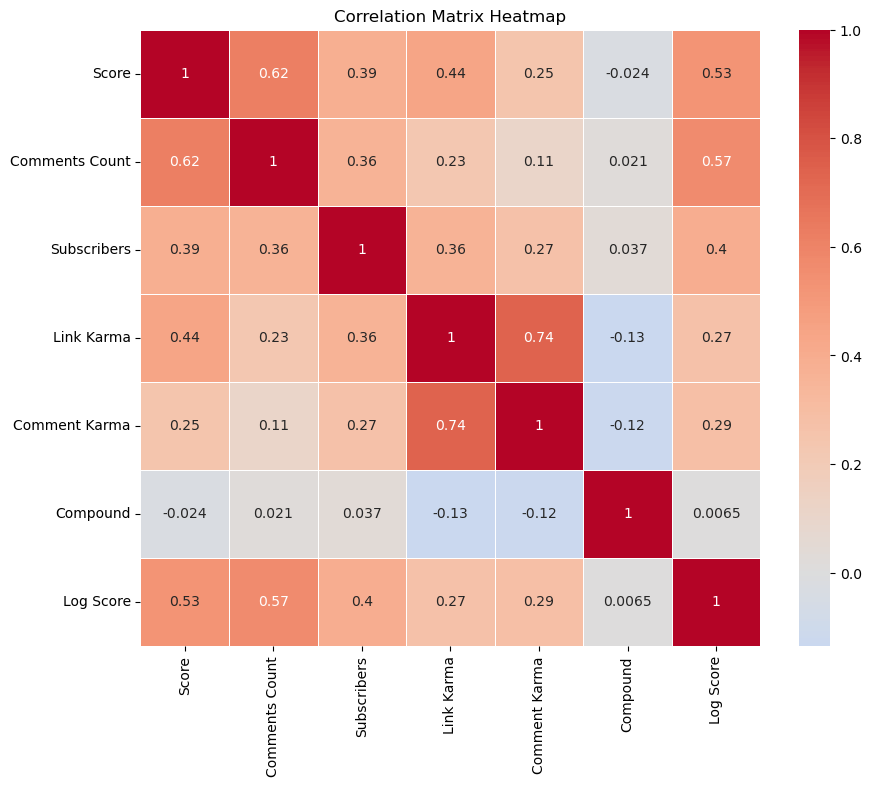

Score           Score             1.000000
Comments Count  Comments Count    1.000000
Compound        Compound          1.000000
Comment Karma   Comment Karma     1.000000
Subscribers     Subscribers       1.000000
Link Karma      Link Karma        1.000000
Log Score       Log Score         1.000000
Comment Karma   Link Karma        0.735017
Link Karma      Comment Karma     0.735017
Score           Comments Count    0.615048
Comments Count  Score             0.615048
Log Score       Comments Count    0.565673
Comments Count  Log Score         0.565673
Log Score       Score             0.526806
Score           Log Score         0.526806
dtype: float64


In [161]:
import pandas as pd

# Assuming `df` is your DataFrame with numerical variables
numerical_df = df_posts.select_dtypes(include=[np.number])
correlation_matrix = numerical_df.corr()
print(correlation_matrix)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()
# Flatten the matrix and filter correlations > 0.8 or < -0.8
high_corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[abs(high_corr_pairs) > 0.5]
print(high_corr_pairs)


----

In [136]:
df_posts.columns

Index(['Post Title', 'Author', 'Score', 'Comments Count', 'Post ID',
       'Post URL', 'Created Date', 'Subreddit', 'Post Text', 'Subscribers',
       'Link Karma', 'Comment Karma', 'Cleaned Post Text', 'Sentiment Scores',
       'Compound', 'Sentiment', 'Log Score'],
      dtype='object')

In [15]:
df_posts.describe()

,Score,Comments Count,Created Date,Subscribers,Link Karma,Comment Karma,Compound
count,230.000000,230.000000,230,2.300000e+02,2.300000e+02,230.000000,230.000000
mean,2505.426087,237.352174,2023-06-23 14:16:30.730434560,5.265914e+06,1.159770e+06,46931.286957,0.276743
min,0.000000,0.000000,2013-12-19 15:42:41,0.000000e+00,1.000000e+00,-25.000000,-0.989500
25%,3.000000,3.250000,2022-12-05 04:07:34.500000,2.842825e+04,7.272500e+02,189.000000,0.000000
50%,136.500000,50.500000,2024-05-15 17:56:59.500000,2.975930e+05,6.975000e+03,2430.000000,0.000000
75%,2009.250000,270.000000,2024-09-29 16:52:20.249999872,2.158542e+06,8.717800e+04,23062.250000,0.895125
max,71981.000000,3556.000000,2024-10-31 19:31:39,4.895539e+07,3.011625e+07,609058.000000,0.999900
std,6981.650716,482.188345,NaN,1.091442e+07,4.577197e+06,107222.564855,0.499688


Testing Normality:

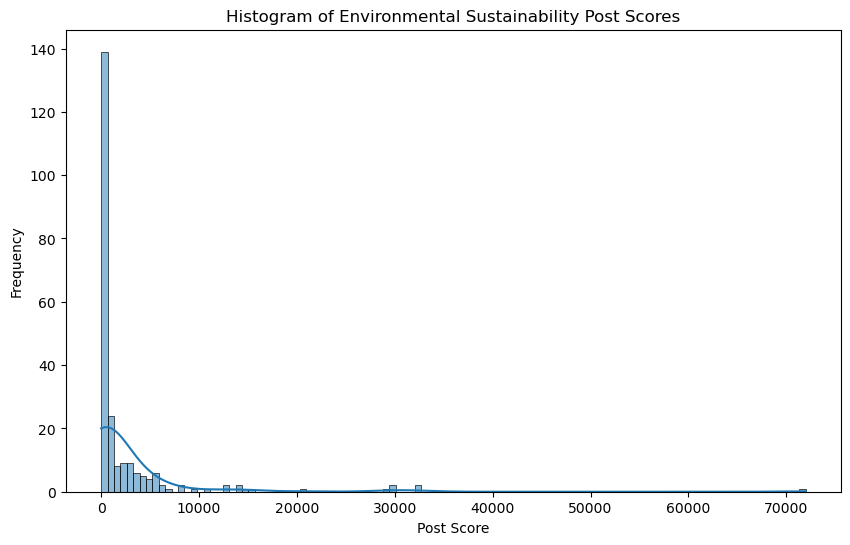

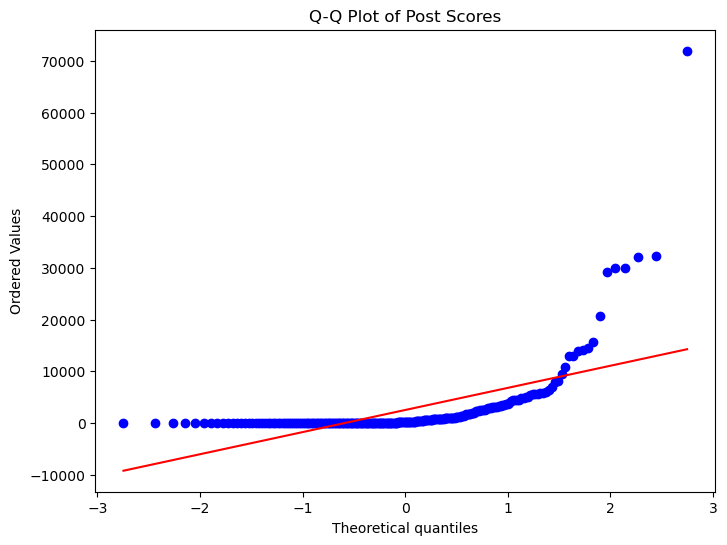

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(df_posts['Score'], kde=True)
plt.title('Histogram of Environmental Sustainability Post Scores')
plt.xlabel('Post Score')
plt.ylabel('Frequency')
plt.show()

# Plot a Q-Q plot to check for normality
plt.figure(figsize=(8, 6))
stats.probplot(df_posts['Score'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Post Scores')
plt.show()

In [18]:
shapiro_stat, shapiro_p = shapiro(df_posts['Score'])
print(f'Shapiro-Wilk Test: Statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}')

# Kolmogorov-Smirnov Test for normality
ks_stat, ks_p = kstest(df_posts['Score'], 'norm', args=(df_posts['Score'].mean(), df_posts['Score'].std()))
print(f'Kolmogorov-Smirnov Test: Statistic={ks_stat:.4f}, p-value={ks_p:.4f}')

Shapiro-Wilk Test: Statistic=0.3793, p-value=0.0000
Kolmogorov-Smirnov Test: Statistic=0.3599, p-value=0.0000


the data is likely not normally distributed (reject the null hypothesis).

In [20]:
data_skewness = skew(df_posts['Score'])
data_kurtosis = kurtosis(df_posts['Score'])

print(f'Skewness of Post Scores: {data_skewness:.4f}')
print(f'Kurtosis of Post Scores: {data_kurtosis:.4f}')

Skewness of Post Scores: 5.9524
Kurtosis of Post Scores: 46.3351


This suggests that the majority of posts have relatively low scores, but a small number of posts have extremely high scores, pulling the tail of the distribution far to the right.

Kurtosis (46.7805): A kurtosis value this high indicates an extremely leptokurtic distribution. In simple terms, the distribution has a very sharp peak and very heavy tails. This suggests that not only are there extreme outliers (posts with very high scores), but also the distribution has a high concentration of scores near the mean and a higher frequency of extreme deviations compared to a normal distribution.

Testing log transformed data normality:

In [23]:
df_posts['Log Score'] = np.log1p(df_posts['Score'])  # log1p(x) = log(1 + x)

# Recheck normality with the transformed data (Log-transformed Score)

shapiro_stat, shapiro_p = shapiro(df_posts['Log Score'])
print(f'Log-transformed Shapiro-Wilk Test: Statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}')

Log-transformed Shapiro-Wilk Test: Statistic=0.9129, p-value=0.0000


This statistic, while closer to 1 than the previous value, still suggests that the data deviates from a perfect normal distribution. The higher value compared to before may indicate that the log transformation brought the data somewhat closer to normality.

p-value = 0.0000: The p-value being effectively zero (less than 0.05) means that the null hypothesis of the data being normally distributed is rejected. Despite the log transformation, the post scores still significantly deviate from a normal distribution.

This means that while the log transformation may have improved the normality slightly, the data remains non-normal

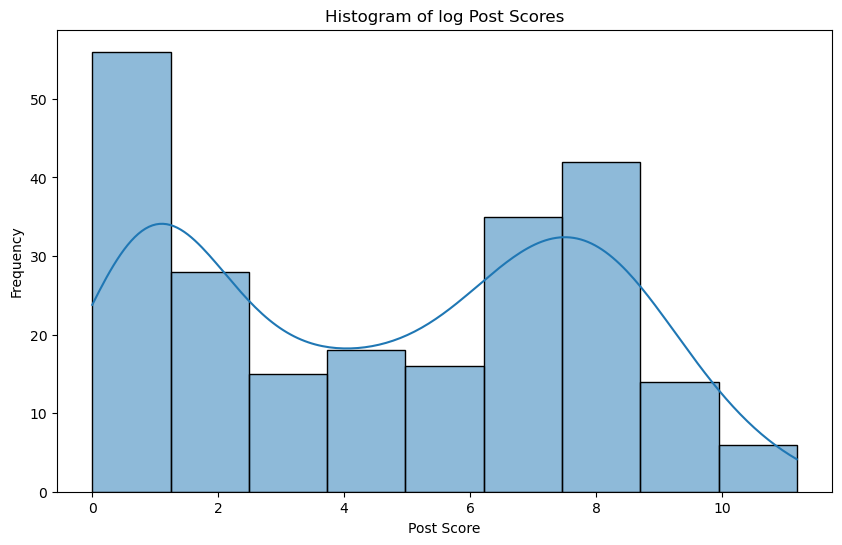

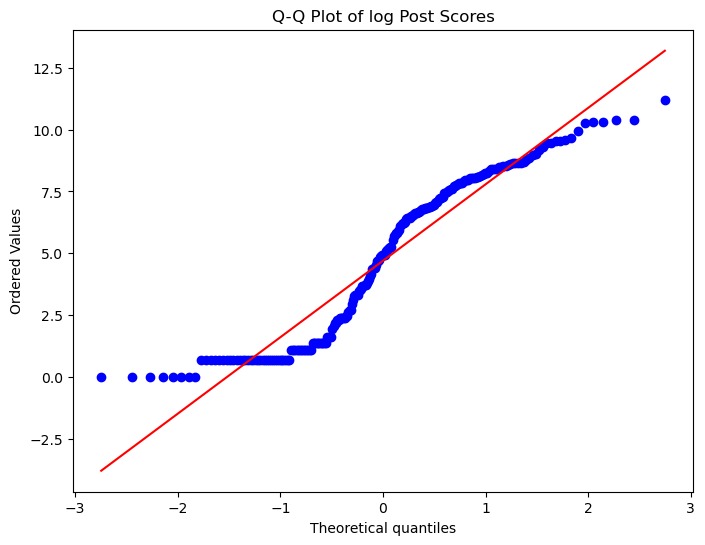

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(df_posts['Log Score'], kde=True)
plt.title('Histogram of log Post Scores')
plt.xlabel('Post Score')
plt.ylabel('Frequency')
plt.show()

# Plot a Q-Q plot to check for normality
plt.figure(figsize=(8, 6))
stats.probplot(df_posts['Log Score'], dist="norm", plot=plt)
plt.title('Q-Q Plot of log Post Scores')
plt.show()

Therefore we may use other statisticcal tests than t-test that do not depend on normality as well as boot strapping to be more confident in the results.

----

test for linearity between the number of posts in each subreddit and the post score

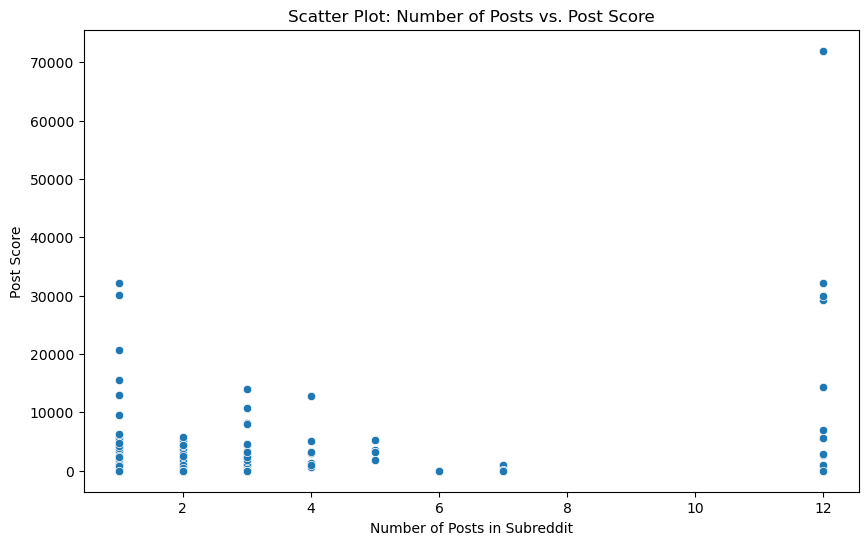

Pearson correlation coefficient: 0.4088840303852046
P-value: 1.1076772520929531e-10
                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     45.77
Date:                Fri, 01 Nov 2024   Prob (F-statistic):           1.11e-10
Time:                        18:50:17   Log-Likelihood:                -2340.6
No. Observations:                 230   AIC:                             4685.
Df Residuals:                     228   BIC:                             4692.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

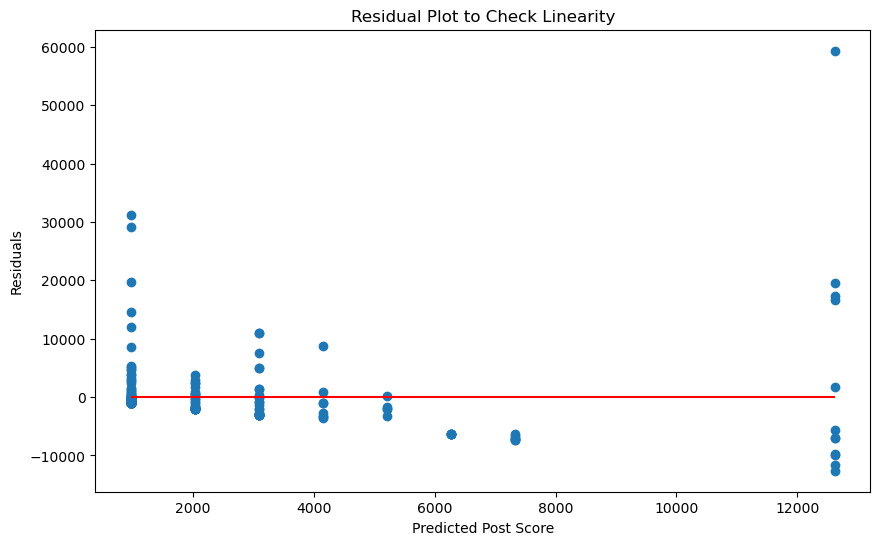

In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.api as sm

# Assuming df_posts is your DataFrame
# Step 1: Count number of posts per subreddit
subreddit_post_counts = df_posts['Subreddit'].value_counts()
df_post_counts = subreddit_post_counts.reset_index()
df_post_counts.columns = ['Subreddit', 'Post Count']

# Step 2: Merge the post counts back to the original DataFrame to associate each post with its subreddit's post count
df_merged = pd.merge(df_posts, df_post_counts, on='Subreddit')

# Step 3: Scatter Plot - Post Count vs. Score
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_merged, x='Post Count', y='Score')
plt.xlabel('Number of Posts in Subreddit')
plt.ylabel('Post Score')
plt.title('Scatter Plot: Number of Posts vs. Post Score')
plt.show()

# Step 4: Calculate Pearson Correlation
correlation, p_value = pearsonr(df_merged['Post Count'], df_merged['Score'])
print(f"Pearson correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

# Step 5: Fit a Linear Model
# Adding a constant to the Post Count for intercept in regression
X = sm.add_constant(df_merged['Post Count'])
model = sm.OLS(df_merged['Score'], X).fit()
print(model.summary())

# Step 6: Residual Plot to further check for linearity
predictions = model.predict(X)
residuals = df_merged['Score'] - predictions

plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals)
plt.hlines(0, min(predictions), max(predictions), colors='red')
plt.xlabel('Predicted Post Score')
plt.ylabel('Residuals')
plt.title('Residual Plot to Check Linearity')
plt.show()


R-squared (0.167): This means that approximately 16.7% of the variability in the Score can be explained by the Post Count. While this is a positive relationship (since the coefficient is positive), it's relatively weak, as the R-squared value is quite low.
there is a clear pattern where residuals are not randomly spread across the range of predicted values.
There is a "fanning out" or "funnel shape" pattern in the residuals, where residuals grow larger as predicted values increase. This pattern indicates heteroscedasticity (non-constant variance), which suggests that the variance of Score is not consistent across values of Post Count.
Homoscedasticity (constant variance) is an assumption of linear regression, and its violation here means the linear model might not be the best fit for this relationship.

Summary:
Linearity: There is some linearity, as indicated by the significant p-value, but the relationship is weak.
Homoscedasticity Violation: The residual plot indicates heteroscedasticity, suggesting that a linear model may not fully capture the relationship.

----

Testing Correlation between # posts of subreddit and its post score:

Correlation between the number of posts and the average score: 0.2097621668399307


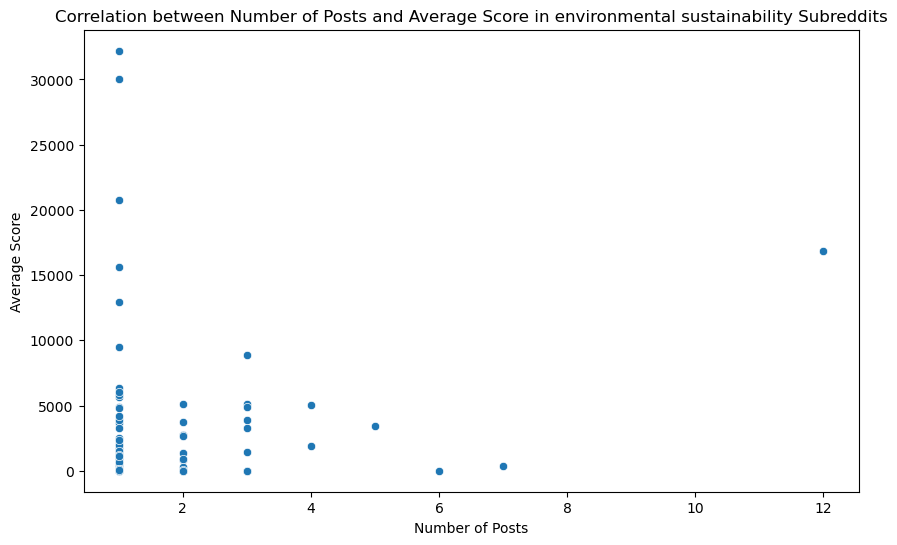

In [28]:
subreddit_stats = df_posts.groupby('Subreddit').agg(
    num_posts=('Post ID', 'count'),
    avg_score=('Score', 'mean'),
    avg_log=('Log Score', 'mean')
).reset_index()

# Investigate the correlation between the number of posts and the average score
correlation = subreddit_stats['num_posts'].corr(subreddit_stats['avg_score'])

# Display the correlation
print(f"Correlation between the number of posts and the average score: {correlation}")

# Plot the relationship between number of posts and average score
plt.figure(figsize=(10,6))
sns.scatterplot(x='num_posts', y='avg_score', data=subreddit_stats)
plt.title('Correlation between Number of Posts and Average Score in environmental sustainability Subreddits')
plt.xlabel('Number of Posts')
plt.ylabel('Average Score')
plt.show()

T test based on the Central Theorem:

In [30]:
n = len(df_posts)

# Calculate the t-statistic
t_stat = correlation * np.sqrt((n - 2) / (1 - correlation**2))

# Calculate the p-value
p_value = stats.t.sf(np.abs(t_stat), df=n-2) * 2  # two-tailed test

# Output the results
print(f"Correlation coefficient: {correlation:.4f}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# Interpret the p-value
alpha = 0.05
if p_value < alpha:
    print(f"The correlation is significant (p < {alpha})")
else:
    print(f"The correlation is not significant (p ≥ {alpha})")

Correlation coefficient: 0.2098
t-statistic: 3.2394
p-value: 0.0014
The correlation is significant (p < 0.05)


In [31]:
spearman_corr, spearman_p = spearmanr(subreddit_stats['num_posts'], subreddit_stats['avg_score'])
print(f"Spearman's Rank Correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

# Kendall's Tau Correlation
kendall_corr, kendall_p = kendalltau(subreddit_stats['num_posts'], subreddit_stats['avg_score'])
print(f"Kendall's Tau Correlation: {kendall_corr:.4f}, p-value: {kendall_p:.4f}")

Spearman's Rank Correlation: 0.1866, p-value: 0.0167
Kendall's Tau Correlation: 0.1522, p-value: 0.0158


Spearman's Rank Correlation indicates a weak but statistically significant positive correlation.
Kendall's Tau Correlation shows a perfect positive correlation, suggesting a strong association between the two variables.

Let's bootstrap to decide:

In [34]:
def bootstrap_correlation(data, num_samples=1000):
    correlations = []
    for _ in range(num_samples):
        sample = resample(data)
        corr, _ = spearmanr(sample['num_posts'], sample['avg_score'])
        correlations.append(corr)
    return np.mean(correlations), np.percentile(correlations, [2.5, 97.5])

mean_corr, conf_interval = bootstrap_correlation(subreddit_stats)
print(f"Bootstrapped Spearman's Correlation: {mean_corr:.4f}")
print(f"95% Confidence Interval: {conf_interval}")

Bootstrapped Spearman's Correlation: 0.1835
95% Confidence Interval: [0.00704374 0.34959199]


Looking a bit into data:

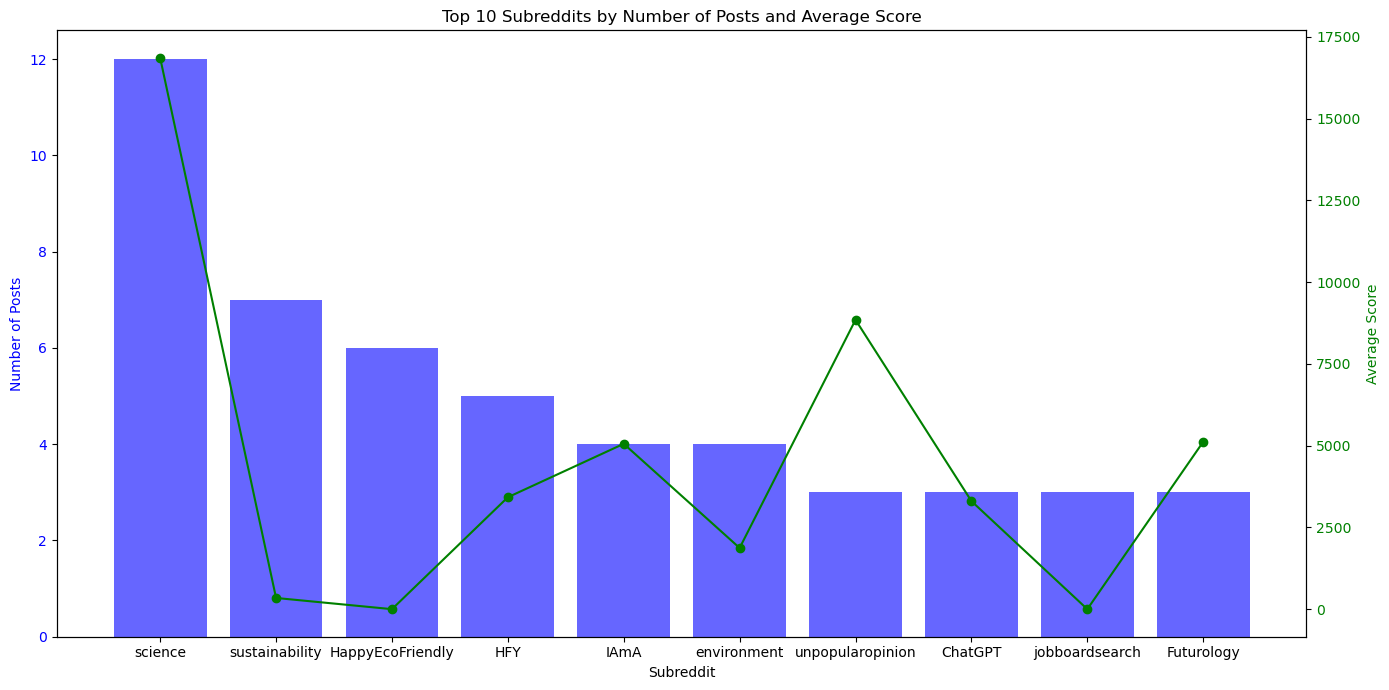

In [36]:
top_10_subreddits = subreddit_stats.sort_values(by='num_posts', ascending=False).head(10)

# Create a figure and axis for dual-axis plot
fig, ax1 = plt.subplots(figsize=(14,7))

# Plot number of posts on the first y-axis
ax1.set_xlabel('Subreddit')
ax1.set_ylabel('Number of Posts', color='blue')
ax1.bar(top_10_subreddits['Subreddit'], top_10_subreddits['num_posts'], color='blue', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the average score
ax2 = ax1.twinx()
ax2.set_ylabel('Average Score', color='green')
ax2.plot(top_10_subreddits['Subreddit'], top_10_subreddits['avg_score'], color='green', marker='o')
ax2.tick_params(axis='y', labelcolor='green')

# Add a title and show the plot
plt.title('Top 10 Subreddits by Number of Posts and Average Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [37]:
science_posts = df_posts[df_posts['Subreddit'].str.lower() == 'science']

# Print all the posts from the 'science' subreddit
science_posts

,Post Title,Author,Score,Comments Count,Post ID,Post URL,Created Date,Subreddit,Post Text,Subscribers,Link Karma,Comment Karma,Cleaned Post Text,Sentiment Scores,Compound,Sentiment,Log Score
1,Researchers describe in a paper how growing al...,giuliomagnifico,29178,724,y0e1sr,https://news.cornell.edu/stories/2022/10/onsho...,2022-10-10 14:53:01,science,N/A,33031204,3271099,197471,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,neutral,10.281205
2,Chemists developed two sustainable plastic alt...,mvea,71981,1115,lo5vco,https://academictimes.com/new-plant-based-plas...,2021-02-20 13:09:12,science,N/A,33031202,30116251,405024,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,neutral,11.184171
5,Chronic inflammation caused by stress is affec...,Wagamaga,2737,220,1bdnuz9,https://www.frontiersin.org/news/2024/03/12/ch...,2024-03-13 11:09:16,science,N/A,33031205,11989860,392341,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,neutral,7.914983
6,A model for ‘sustainable’ US beef production -...,mvea,32133,3287,7mebyz,https://www.nature.com/articles/s41559-017-0390-5,2017-12-27 11:40:58,science,N/A,33031204,30116251,405024,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,neutral,10.377670
7,India can sustainably enhance its food supply ...,MistWeaver80,29912,943,e7hp20,https://www.pnas.org/content/early/2019/11/20/...,2019-12-07 19:17:29,science,N/A,33031202,4936449,76525,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,neutral,10.306048
8,Low-meat diets nutritionally adequate for reco...,tzaeru,2836,570,xtkygh,https://academic.oup.com/ajcn/advance-article-...,2022-10-02 12:00:32,science,N/A,33031205,7557,97200,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,neutral,7.950502
16,Fracking is one of the least sustainable ways ...,mvea,5688,275,7qrvka,http://www.independent.co.uk/environment/frack...,2018-01-16 13:04:45,science,N/A,33031204,30116251,405024,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,neutral,8.646290
38,Sustainable alternatives key to combating fast...,Wagamaga,929,44,17nq4bq,https://www.sfu.ca/sfunews/stories/2023/11/sus...,2023-11-04 18:05:25,science,N/A,33031207,11989860,392341,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,neutral,6.835185
97,Science Discussion Series: Batteries seem to p...,ScienceModerator,14424,1258,bj3fpd,https://www.reddit.com/r/science/comments/bj3f...,2019-04-30 15:40:15,science,[Hello Reddit!](https://i.imgur.com/sqOjWz6.pn...,33031207,114236,691,hello reddit group scientist engineer academia...,"{'neg': 0.018, 'neu': 0.811, 'pos': 0.171, 'co...",0.9962,positive,9.576718
148,Science discussion series: We are an interdisc...,ScienceModerator,5579,824,b91hql,https://www.reddit.com/r/science/comments/b91h...,2019-04-03 20:11:58,science,[Hi Reddit](https://i.imgur.com/sqOjWz6.png)! ...,33031208,114236,691,hi reddit today discussion coming u national a...,"{'neg': 0.053, 'neu': 0.823, 'pos': 0.124, 'co...",0.9776,positive,8.626944


In [38]:
for index, title in enumerate(science_posts['Post Title'], start=1):
    print(f"Post {index}:\n{title}")
    print("-" * 40)

Post 1:
Researchers describe in a paper how growing algae onshore could close a projected gap in society’s future nutritional demands while also improving environmental sustainability
----------------------------------------
Post 2:
Chemists developed two sustainable plastic alternatives to polyethylene, derived from plants, that can be recycled with a recovery rate of more than 96%, as low-waste, environmentally friendly replacements to conventional fossil fuel-based plastics. (Nature, 17 Feb)
----------------------------------------
Post 3:
Chronic inflammation caused by stress is affecting our collective thinking and behavior, and it’s keeping society in a “self-sustaining cycle of societal dysfunction and environmental degradation” which is keeping us from taking action on issues like climate change and social unrest
----------------------------------------
Post 4:
A model for ‘sustainable’ US beef production - If Americans reduced their mean beef consumption from the current ≈460 

Correlation between the number of members (subscribers) and the average score:

Correlation between the number of members (subscribers) and the average score: 0.3109135600082119


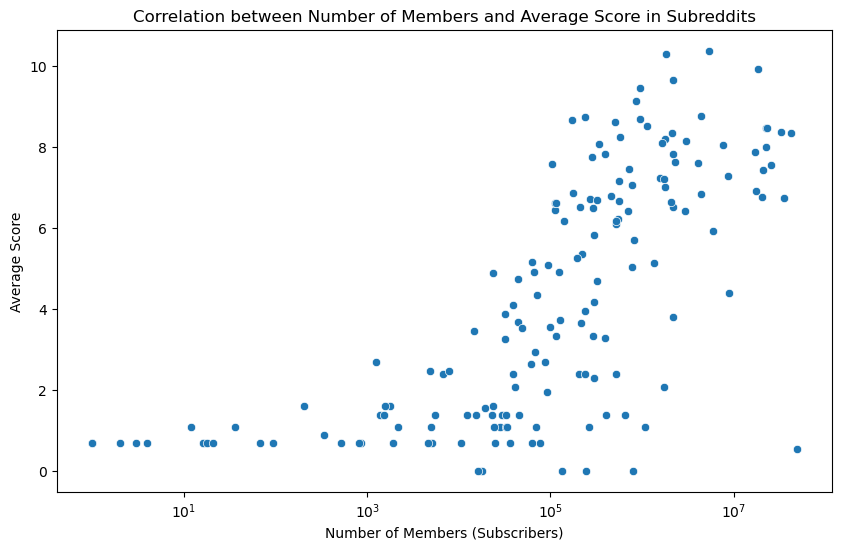

In [40]:
subreddit_stats = df_posts.groupby('Subreddit').agg(
    num_posts=('Post ID', 'count'),
    avg_score=('Log Score', 'mean'),
    subscribers=('Subscribers', 'first'),
    avg_log=('Log Score', 'mean')# Get the subscriber count for each subreddit
).reset_index()

# Investigate the correlation between the number of members and the average score
correlation = subreddit_stats['subscribers'].corr(subreddit_stats['avg_score'])

# Display the correlation
print(f"Correlation between the number of members (subscribers) and the average score: {correlation}")

# Plot the relationship between number of members and average score
plt.figure(figsize=(10,6))
sns.scatterplot(x='subscribers', y='avg_score', data=subreddit_stats)
plt.title('Correlation between Number of Members and Average Score in Subreddits')
plt.xlabel('Number of Members (Subscribers)')
plt.ylabel('Average Score')
plt.xscale('log')  # Use log scale for subscribers if the range is wide
plt.show()

t significancy test:

In [42]:
n = len(df_posts)

# Calculate the t-statistic
t_stat = correlation * np.sqrt((n - 2) / (1 - correlation**2))

# Calculate the p-value
p_value = stats.t.sf(np.abs(t_stat), df=n-2) * 2  # two-tailed test

# Output the results
print(f"Correlation coefficient: {correlation:.4f}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# Interpret the p-value
alpha = 0.05
if p_value < alpha:
    print(f"The correlation is significant (p < {alpha})")
else:
    print(f"The correlation is not significant (p ≥ {alpha})")

Correlation coefficient: 0.3109
t-statistic: 4.9395
p-value: 0.0000
The correlation is significant (p < 0.05)


In [43]:
spearman_corr, spearman_p = spearmanr(subreddit_stats['subscribers'], subreddit_stats['avg_score'])
print(f"Spearman's Rank Correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

# Kendall's Tau Correlation
kendall_corr, kendall_p = kendalltau(subreddit_stats['subscribers'], subreddit_stats['avg_score'])
print(f"Kendall's Tau Correlation: {kendall_corr:.4f}, p-value: {kendall_p:.4f}")

Spearman's Rank Correlation: 0.7421, p-value: 0.0000
Kendall's Tau Correlation: 0.5616, p-value: 0.0000


In [44]:
def bootstrap_correlation(data, num_samples=1000):
    correlations = []
    for _ in range(num_samples):
        sample = resample(data)
        corr, _ = spearmanr(sample['subscribers'], sample['avg_score'])
        correlations.append(corr)
    return np.mean(correlations), np.percentile(correlations, [2.5, 97.5])

mean_corr, conf_interval = bootstrap_correlation(subreddit_stats)
print(f"Bootstrapped Spearman's Correlation: {mean_corr:.4f}")
print(f"95% Confidence Interval: {conf_interval}")

Bootstrapped Spearman's Correlation: 0.7388
95% Confidence Interval: [0.64154141 0.81815697]


A closer look into data:

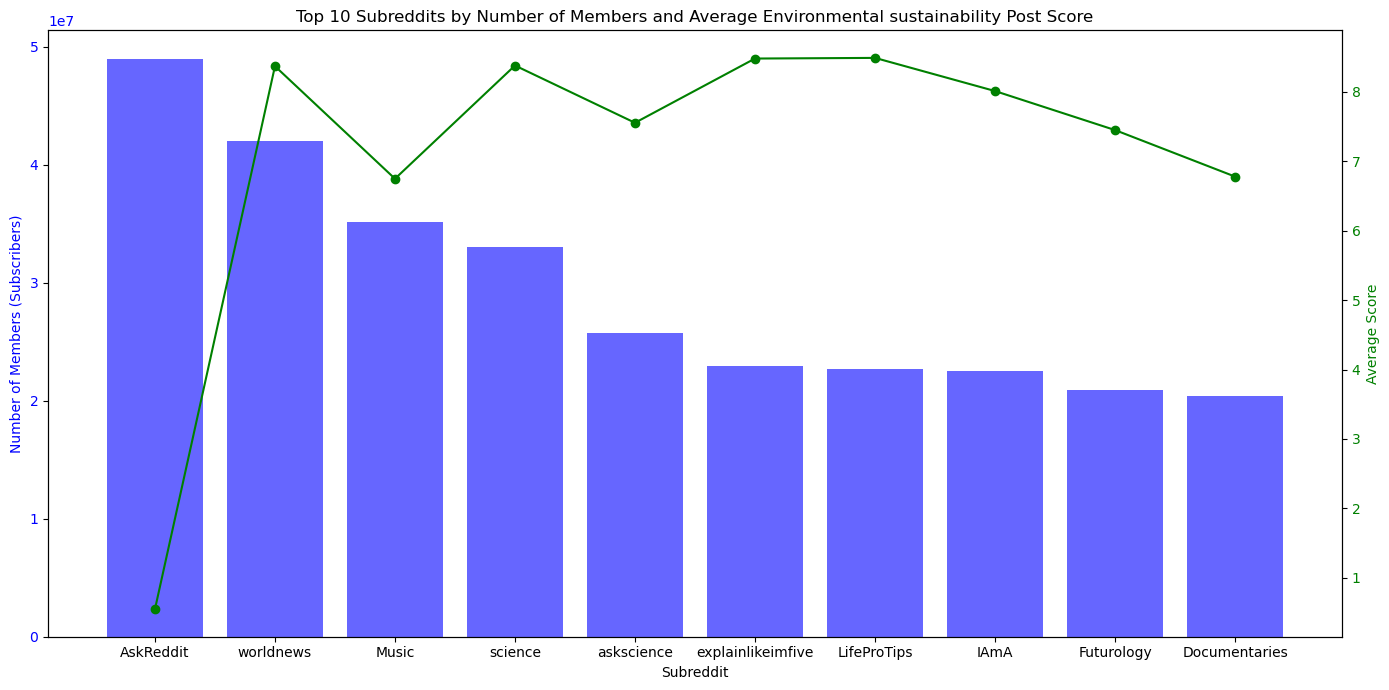

In [46]:
top_10_subreddits = subreddit_stats.sort_values(by='subscribers', ascending=False).head(10)

# Create a figure and axis for the dual-axis plot
fig, ax1 = plt.subplots(figsize=(14,7))

# Plot the number of subscribers on the first y-axis
ax1.set_xlabel('Subreddit')
ax1.set_ylabel('Number of Members (Subscribers)', color='blue')
ax1.bar(top_10_subreddits['Subreddit'], top_10_subreddits['subscribers'], color='blue', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the average score
ax2 = ax1.twinx()
ax2.set_ylabel('Average Score', color='green')
ax2.plot(top_10_subreddits['Subreddit'], top_10_subreddits['avg_score'], color='green', marker='o')
ax2.tick_params(axis='y', labelcolor='green')

# Add a title and show the plot
plt.title('Top 10 Subreddits by Number of Members and Average Environmental sustainability Post Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [47]:
ask_posts = df_posts[df_posts['Subreddit'].str.lower() == 'askreddit']

# Print all the posts from the 'science' subreddit
ask_posts

,Post Title,Author,Score,Comments Count,Post ID,Post URL,Created Date,Subreddit,Post Text,Subscribers,Link Karma,Comment Karma,Cleaned Post Text,Sentiment Scores,Compound,Sentiment,Log Score
135,How can we create a global economic system tha...,RemoteMajor9739,0,16,1easfnr,https://www.reddit.com/r/AskReddit/comments/1e...,2024-07-24 06:22:51,AskReddit,N/A,48955380,1,0,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0,neutral,0.000000
196,What are some ways to make travel more sustain...,Status_Lab3251,2,9,1eiy0zc,https://www.reddit.com/r/AskReddit/comments/1e...,2024-08-03 10:08:09,AskReddit,N/A,48955390,13,16,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0,neutral,1.098612


In [48]:
for index, title in enumerate(ask_posts['Post Title'], start=1):
    print(f"Post {index}:\n{title}")
    print("-" * 40)

Post 1:
How can we create a global economic system that prioritizes both human well-being and environmental sustainability? What radical changes would need to occur to balance economic growth with social equity and ecological preservation?
----------------------------------------
Post 2:
What are some ways to make travel more sustainable and environmentally friendly?
----------------------------------------


In [49]:
world_posts = df_posts[df_posts['Subreddit'].str.lower() == 'worldnews']

# Print all the posts from the 'science' subreddit
world_posts

,Post Title,Author,Score,Comments Count,Post ID,Post URL,Created Date,Subreddit,Post Text,Subscribers,Link Karma,Comment Karma,Cleaned Post Text,Sentiment Scores,Compound,Sentiment,Log Score
4,UK Budget 2023: Nuclear power to be reclassed ...,ead09,4425,487,11rwobu,https://www.scotsman.com/news/environment/budg...,2023-03-15 14:38:23,worldnews,N/A,42039386,23394,21507,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0,neutral,8.395252
9,"The true cost of cheap, unhealthy food is a sp...",ManiaforBeatles,8115,539,cdus2t,https://www.theguardian.com/environment/2019/j...,2019-07-16 11:31:31,worldnews,N/A,42039392,15179714,208012,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0,neutral,9.001593
12,Overconsumption and growth economy key drivers...,BattlemechJohnBrown,2227,666,hdhqno,https://phys.org/news/2020-06-overconsumption-...,2020-06-22 02:22:57,worldnews,N/A,42039392,313114,42605,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0,neutral,7.708860


In [50]:
for index, title in enumerate(world_posts['Post Title'], start=1):
    print(f"Post {index}:\n{title}")
    print("-" * 40)

Post 1:
UK Budget 2023: Nuclear power to be reclassed as 'environmentally sustainable'
----------------------------------------
Post 2:
The true cost of cheap, unhealthy food is a spiralling public health crisis and environmental destruction, according to a high-level commission. It said the UK’s food and farming system must be radically transformed and become sustainable within 10 years.
----------------------------------------
Post 3:
Overconsumption and growth economy key drivers of environmental crises - study | The researchers say that "green" or "sustainable growth" is a myth. "As long as there is growth—both economically and in population—technology cannot keep up, the overall environmental impacts will only increase."
----------------------------------------


Again Science

Correlation between sentiment (compound score) and post scores:

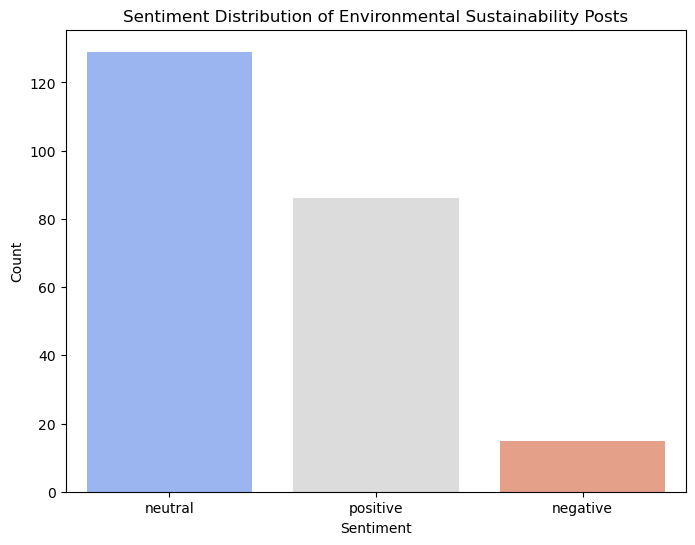

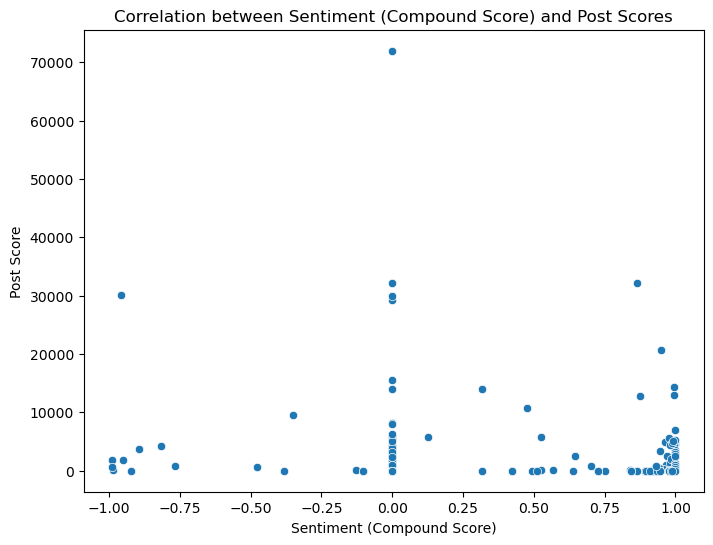

Correlation between sentiment (compound score) and post scores: -0.02


In [53]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=df_posts, palette='coolwarm')
plt.title('Sentiment Distribution of Environmental Sustainability Posts')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Compound', y='Score', data=df_posts)
plt.title('Correlation between Sentiment (Compound Score) and Post Scores')
plt.xlabel('Sentiment (Compound Score)')
plt.ylabel('Post Score')
plt.show()
correlation = df_posts['Compound'].corr(df_posts['Score'])
print(f'Correlation between sentiment (compound score) and post scores: {correlation:.2f}')

t test:

In [55]:
n = len(df_posts)

# Calculate the t-statistic
t_stat = correlation * np.sqrt((n - 2) / (1 - correlation**2))

# Calculate the p-value
p_value = stats.t.sf(np.abs(t_stat), df=n-2) * 2  # two-tailed test

# Output the results
print(f"Correlation coefficient: {correlation:.4f}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# Interpret the p-value
alpha = 0.05
if p_value < alpha:
    print(f"The correlation is significant (p < {alpha})")
else:
    print(f"The correlation is not significant (p ≥ {alpha})")

Correlation coefficient: -0.0238
t-statistic: -0.3599
p-value: 0.7192
The correlation is not significant (p ≥ 0.05)


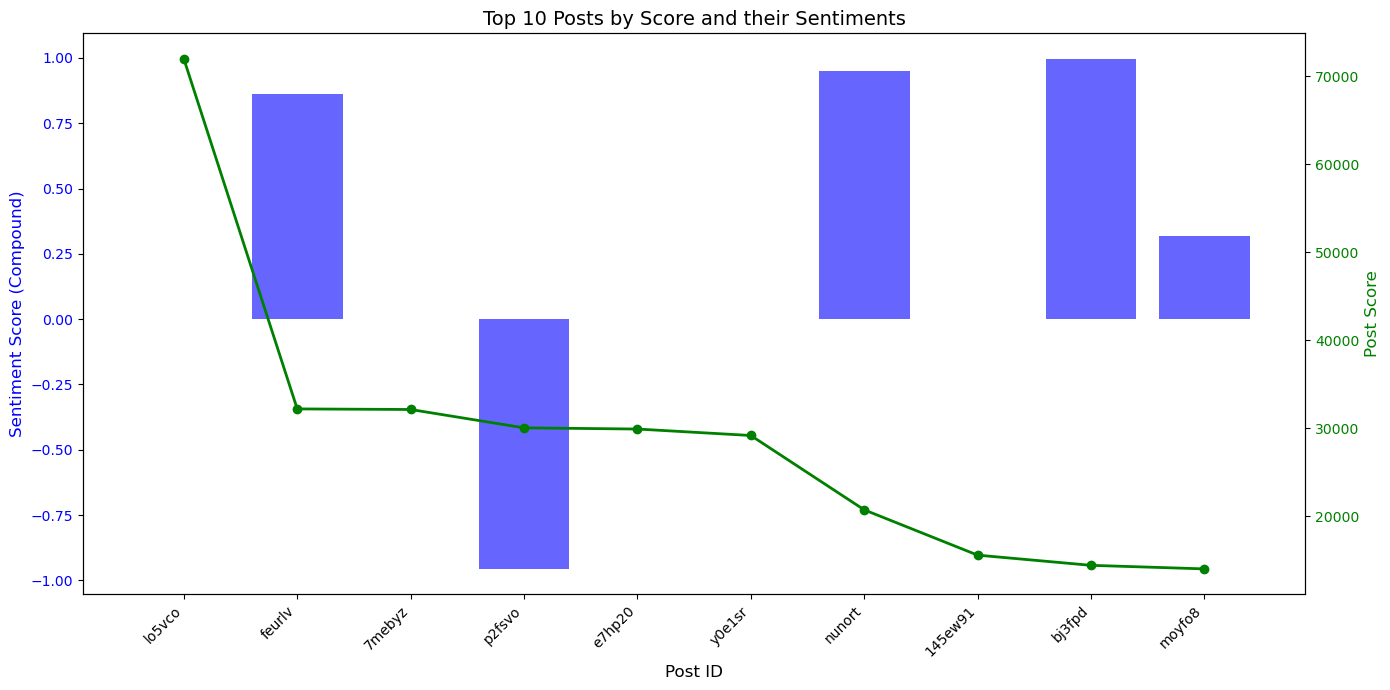

,Post Title,Author,Score,Comments Count,Post ID,Post URL,Created Date,Subreddit,Post Text,Subscribers,Link Karma,Comment Karma,Cleaned Post Text,Sentiment Scores,Compound,Sentiment,Log Score
2,Chemists developed two sustainable plastic alt...,mvea,71981,1115,lo5vco,https://academictimes.com/new-plant-based-plas...,2021-02-20 13:09:12,science,N/A,33031202,30116251,405024,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,neutral,11.184171
3,YSK if you're thinking about hoarding toilet p...,Assume_Utopia,32199,1543,feurlv,https://www.reddit.com/r/YouShouldKnow/comment...,2020-03-07 13:54:42,YouShouldKnow,"Actually, just get one no matter what. I was s...",5425030,25913,71461,actually get one matter sceptical first worth ...,"{'neg': 0.056, 'neu': 0.615, 'pos': 0.328, 'co...",0.8625,positive,10.379722
6,A model for ‘sustainable’ US beef production -...,mvea,32133,3287,7mebyz,https://www.nature.com/articles/s41559-017-0390-5,2017-12-27 11:40:58,science,N/A,33031204,30116251,405024,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,neutral,10.377670
52,Why the FUCK are we still catering to billiona...,audyaudvi,30046,3556,p2fsvo,https://www.reddit.com/r/TooAfraidToAsk/commen...,2021-08-11 17:52:03,TooAfraidToAsk,"Seriously, what? Why? Why are we enabling the ...",1827643,25988,6440,seriously enabling people fucking planet live ...,"{'neg': 0.244, 'neu': 0.548, 'pos': 0.209, 'co...",-0.9556,negative,10.310518
7,India can sustainably enhance its food supply ...,MistWeaver80,29912,943,e7hp20,https://www.pnas.org/content/early/2019/11/20/...,2019-12-07 19:17:29,science,N/A,33031202,4936449,76525,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,neutral,10.306048
1,Researchers describe in a paper how growing al...,giuliomagnifico,29178,724,y0e1sr,https://news.cornell.edu/stories/2022/10/onsho...,2022-10-10 14:53:01,science,N/A,33031204,3271099,197471,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,neutral,10.281205
99,TIFU by making my date believe I lead him to a...,panda-pantsu,20730,369,nunort,https://www.reddit.com/r/tifu/comments/nunort/...,2021-06-07 23:10:00,tifu,"It happened a few months ago, but I laugh ev...",18610873,5182,3078,happened month ago laugh every time remember m...,"{'neg': 0.13, 'neu': 0.655, 'pos': 0.214, 'com...",0.9490,positive,9.939385
0,"Ah yes, the cattle industry. The best example ...",TheRealHogshead,15582,511,145ew91,https://i.redd.it/jbm8k1c4r15b1.jpg,2023-06-09 21:49:30,terriblefacebookmemes,N/A,2207976,47326,12175,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,neutral,9.653936
97,Science Discussion Series: Batteries seem to p...,ScienceModerator,14424,1258,bj3fpd,https://www.reddit.com/r/science/comments/bj3f...,2019-04-30 15:40:15,science,[Hello Reddit!](https://i.imgur.com/sqOjWz6.pn...,33031207,114236,691,hello reddit group scientist engineer academia...,"{'neg': 0.018, 'neu': 0.811, 'pos': 0.171, 'co...",0.9962,positive,9.576718
81,Living an environmentally friendly life is a p...,WantedHHHJJJ,14020,759,moyfo8,https://www.reddit.com/r/unpopularopinion/comm...,2021-04-11 22:16:34,unpopularopinion,Many poor people do not have the financial cap...,4389215,6395,3504,many poor people financial capability environm...,"{'neg': 0.148, 'neu': 0.688, 'pos': 0.164, 'co...",0.3167,positive,9.548311


In [56]:
top_10_posts = df_posts.sort_values(by='Score', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(14,7))

ax1.set_xlabel('Post ID', fontsize=12)
ax1.set_ylabel('Sentiment Score (Compound)', color='blue', fontsize=12)
ax1.bar(top_10_posts['Post ID'], top_10_posts['Compound'], color='blue', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')

plt.xticks(rotation=45, ha='right')

ax2 = ax1.twinx()
ax2.set_ylabel('Post Score', color='green', fontsize=12)
ax2.plot(top_10_posts['Post ID'], top_10_posts['Score'], color='green', marker='o', linewidth=2)
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Top 10 Posts by Score and their Sentiments', fontsize=14)

plt.tight_layout()

plt.show()

top_10_posts

In [57]:
top_10_posts[top_10_posts['Post ID'] == 'p2fsvo']

,Post Title,Author,Score,Comments Count,Post ID,Post URL,Created Date,Subreddit,Post Text,Subscribers,Link Karma,Comment Karma,Cleaned Post Text,Sentiment Scores,Compound,Sentiment,Log Score
52,Why the FUCK are we still catering to billiona...,audyaudvi,30046,3556,p2fsvo,https://www.reddit.com/r/TooAfraidToAsk/commen...,2021-08-11 17:52:03,TooAfraidToAsk,"Seriously, what? Why? Why are we enabling the ...",1827643,25988,6440,seriously enabling people fucking planet live ...,"{'neg': 0.244, 'neu': 0.548, 'pos': 0.209, 'co...",-0.9556,negative,10.310518


In [58]:
top_10_posts[top_10_posts['Post ID'] == 'lo5vco']

,Post Title,Author,Score,Comments Count,Post ID,Post URL,Created Date,Subreddit,Post Text,Subscribers,Link Karma,Comment Karma,Cleaned Post Text,Sentiment Scores,Compound,Sentiment,Log Score
2,Chemists developed two sustainable plastic alt...,mvea,71981,1115,lo5vco,https://academictimes.com/new-plant-based-plas...,2021-02-20 13:09:12,science,N/A,33031202,30116251,405024,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0,neutral,11.184171


Correlation between Link Karma and Post Scores:

In [60]:
author_avg_score = df_posts.groupby('Author')['Score'].mean().reset_index()
author_avg_score.columns = ['Author', 'Avg_Score']

author_karma_data = df_posts[['Author', 'Link Karma', 'Comment Karma']].drop_duplicates()

author_stats = pd.merge(author_avg_score, author_karma_data, on='Author', how='inner')

correlation_matrix = author_stats[['Avg_Score', 'Link Karma', 'Comment Karma']].corr()

print(correlation_matrix)

               Avg_Score  Link Karma  Comment Karma
Avg_Score       1.000000    0.424586       0.221133
Link Karma      0.424586    1.000000       0.657327
Comment Karma   0.221133    0.657327       1.000000


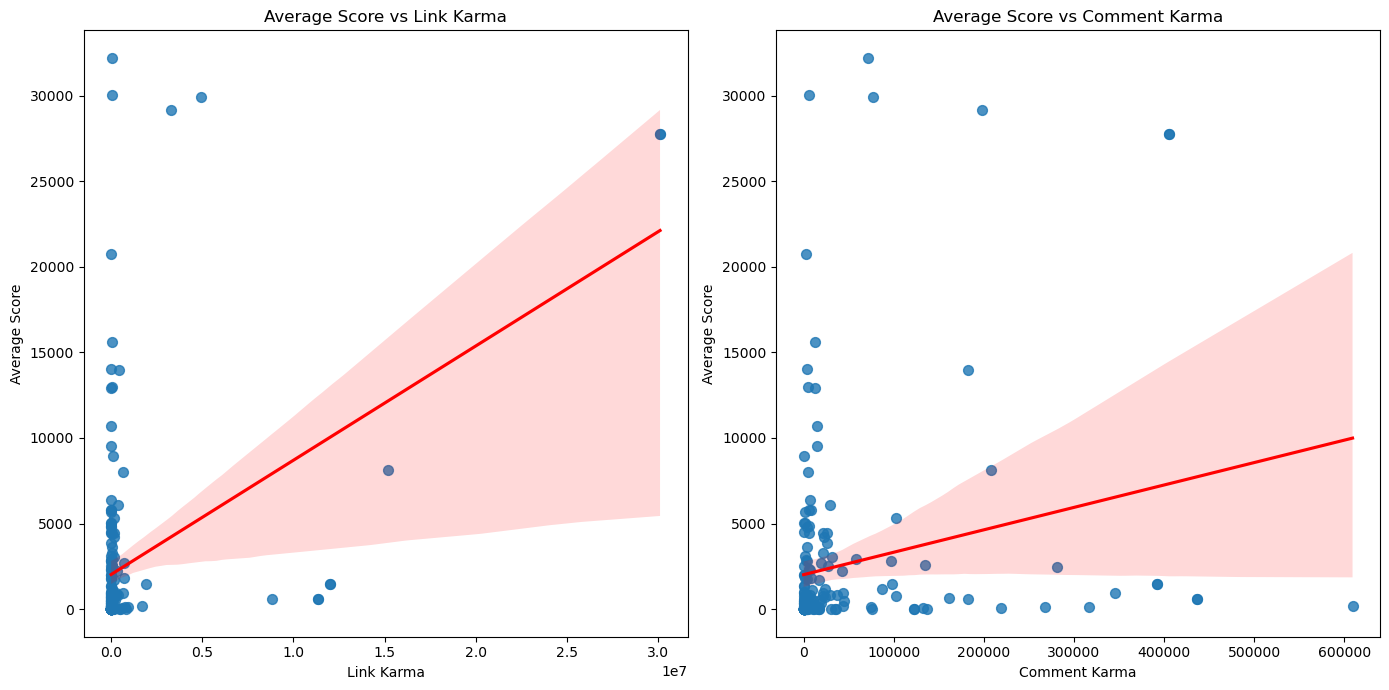

In [61]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.regplot(x='Link Karma', y='Avg_Score', data=author_stats, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Average Score vs Link Karma')
plt.xlabel('Link Karma')
plt.ylabel('Average Score')

plt.subplot(1, 2, 2)
sns.regplot(x='Comment Karma', y='Avg_Score', data=author_stats, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Average Score vs Comment Karma')
plt.xlabel('Comment Karma')
plt.ylabel('Average Score')

plt.tight_layout()
plt.show()

In [62]:
link_karma_corr = author_stats['Avg_Score'].corr(author_stats['Link Karma'])

n = len(author_stats)  

t_stat = link_karma_corr * np.sqrt((n - 2) / (1 - link_karma_corr**2))

p_value = stats.t.sf(np.abs(t_stat), df=n-2) * 2

print(f"Correlation coefficient: {link_karma_corr:.4f}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

alpha = 0.05  
if p_value < alpha:
    print(f"The correlation is significant (p < {alpha})")
else:
    print(f"The correlation is not significant (p ≥ {alpha})")

Correlation coefficient: 0.4246
t-statistic: 6.3785
p-value: 0.0000
The correlation is significant (p < 0.05)


In [63]:
spearman_corr, spearman_p = spearmanr(author_stats['Link Karma'], author_stats['Avg_Score'])
print(f"Spearman's Rank Correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

# Kendall's Tau Correlation
kendall_corr, kendall_p = kendalltau(author_stats['Link Karma'], author_stats['Avg_Score'])
print(f"Kendall's Tau Correlation: {kendall_corr:.4f}, p-value: {kendall_p:.4f}")

Spearman's Rank Correlation: 0.5817, p-value: 0.0000
Kendall's Tau Correlation: 0.4003, p-value: 0.0000


In [64]:
comment_karma_corr = author_stats['Avg_Score'].corr(author_stats['Comment Karma'])

t_stat_comment = comment_karma_corr * np.sqrt((n - 2) / (1 - comment_karma_corr**2))
p_value_comment = stats.t.sf(np.abs(t_stat_comment), df=n-2) * 2  

print(f"Comment Karma Correlation: {comment_karma_corr:.4f}")
print(f"Comment Karma t-statistic: {t_stat_comment:.4f}")
print(f"Comment Karma p-value: {p_value_comment:.4f}")

if p_value_comment < alpha:
    print(f"The correlation with Comment Karma is significant (p < {alpha})")
else:
    print(f"The correlation with Comment Karma is not significant (p ≥ {alpha})")

Comment Karma Correlation: 0.2211
Comment Karma t-statistic: 3.0841
Comment Karma p-value: 0.0024
The correlation with Comment Karma is significant (p < 0.05)


In [65]:
def bootstrap_correlation(data, num_samples=1000):
    correlations = []
    for _ in range(num_samples):
        sample = resample(data)
        corr, _ = spearmanr(sample['Link Karma'], sample['Score'])
        correlations.append(corr)
    return np.mean(correlations), np.percentile(correlations, [2.5, 97.5])

mean_corr, conf_interval = bootstrap_correlation(df_posts)
print(f"Bootstrapped Spearman's Correlation: {mean_corr:.4f}")
print(f"95% Confidence Interval: {conf_interval}")

Bootstrapped Spearman's Correlation: 0.5532
95% Confidence Interval: [0.46406933 0.63305811]


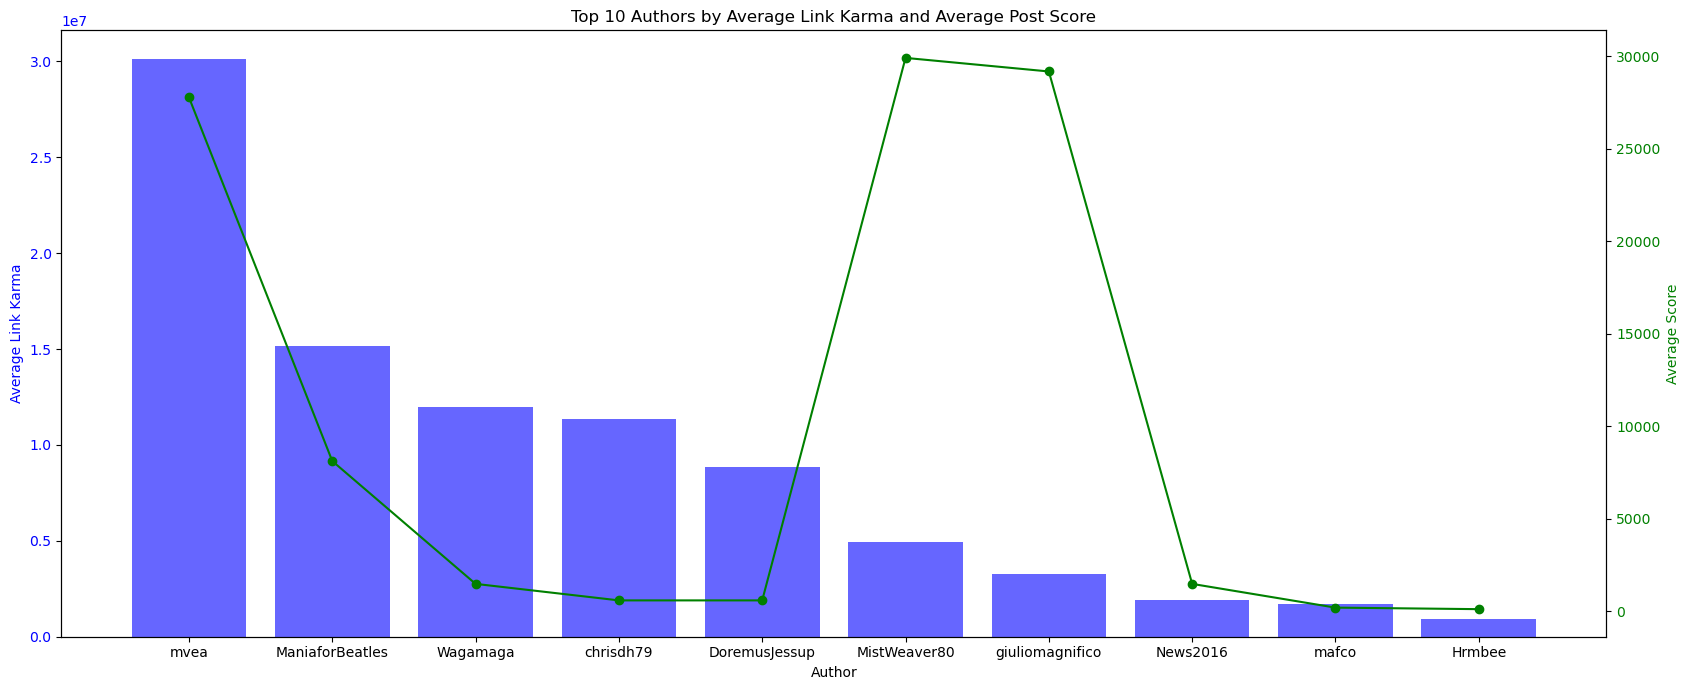

In [66]:
author_stats = df_posts.groupby('Author').agg(
    avg_link_karma=('Link Karma', 'mean'),  # Average link karma by each author
    avg_score=('Score', 'mean')             # Average score of posts by the author
).reset_index()

top_10_authors = author_stats.sort_values(by='avg_link_karma', ascending=False).head(10)

# Step 3: Create a figure and axis for the dual-axis plot
fig, ax1 = plt.subplots(figsize=(17,7))

# Plot the average link karma as bars on the first y-axis
ax1.set_xlabel('Author')
ax1.set_ylabel('Average Link Karma', color='blue')
ax1.bar(top_10_authors['Author'], top_10_authors['avg_link_karma'], color='blue', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')

# Step 4: Create a second y-axis for the average post score
ax2 = ax1.twinx()
ax2.set_ylabel('Average Score', color='green')
ax2.plot(top_10_authors['Author'], top_10_authors['avg_score'], color='green', marker='o')
ax2.tick_params(axis='y', labelcolor='green')

# Step 5: Add a title and show the plot
plt.title('Top 10 Authors by Average Link Karma and Average Post Score')
plt.xticks(rotation=180)
plt.tight_layout()
plt.show()

In [67]:
yuri_posts = df_posts[df_posts['Author'].str.lower() == 'yuritopiaposadism']

# Print all the posts from the 'science' subreddit
print(yuri_posts)

Empty DataFrame
Columns: [Post Title, Author, Score, Comments Count, Post ID, Post URL, Created Date, Subreddit, Post Text, Subscribers, Link Karma, Comment Karma, Cleaned Post Text, Sentiment Scores, Compound, Sentiment, Log Score]
Index: []


In [68]:
for index, title in enumerate(yuri_posts['Post Title'], start=1):
    print(f"Post {index}:\n{title}")
    print("-" * 40)

Correlation between Number of Posts by Authors and Post Scores:

In [70]:
author_post_count = df_posts.groupby('Author').size().reset_index(name='Num_Posts')

author_avg_score = df_posts.groupby('Author')['Score'].mean().reset_index(name='Avg_Score')

author_stats = pd.merge(author_post_count, author_avg_score, on='Author')

n = len(author_stats)

pearson_corr, pearson_p_value = stats.pearsonr(author_stats['Num_Posts'], author_stats['Avg_Score'])

t_stat_pearson = pearson_corr * np.sqrt((n - 2) / (1 - pearson_corr**2))
p_value_ttest_pearson = stats.t.sf(np.abs(t_stat_pearson), df=n-2) * 2  # two-tailed test

print(f"Pearson's Correlation: {pearson_corr:.4f}, p-value: {pearson_p_value:.4f}")
print(f"Pearson's Correlation t-statistic: {t_stat_pearson:.4f}, p-value: {p_value_ttest_pearson:.4f}")

alpha = 0.05  # significance level
if p_value_ttest_pearson < alpha:
    print(f"The Pearson correlation is significant (p < {alpha})")
else:
    print(f"The Pearson correlation is not significant (p ≥ {alpha})")

Pearson's Correlation: 0.0089, p-value: 0.9043
Pearson's Correlation t-statistic: 0.1204, p-value: 0.9043
The Pearson correlation is not significant (p ≥ 0.05)


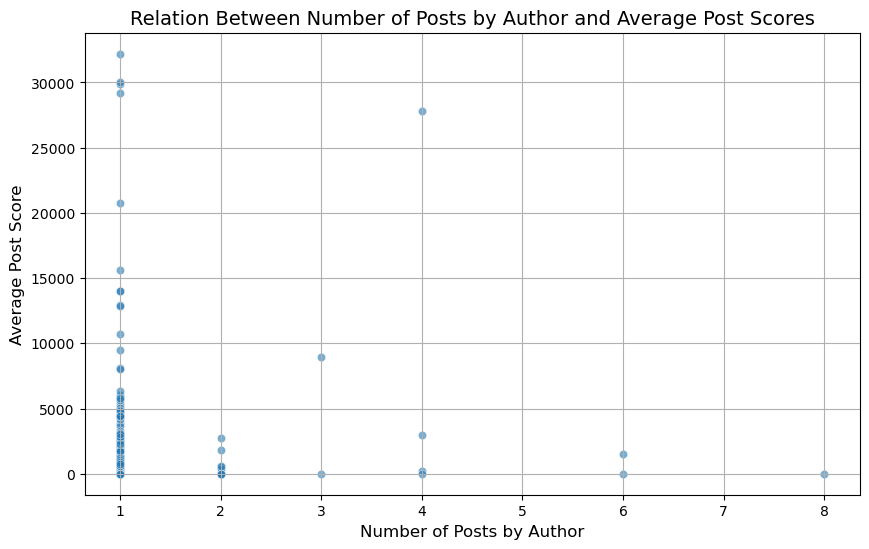

In [71]:
author_post_counts = df_posts.groupby('Author').size().reset_index(name='Num Posts')

author_avg_scores = df_posts.groupby('Author')['Score'].mean().reset_index(name='Avg_Score')

author_stats = pd.merge(author_post_counts, author_avg_scores, on='Author')

plt.figure(figsize=(10, 6))

sns.scatterplot(x='Num Posts', y='Avg_Score', data=author_stats, alpha=0.6)
plt.title('Relation Between Number of Posts by Author and Average Post Scores', fontsize=14)
plt.xlabel('Number of Posts by Author', fontsize=12)
plt.ylabel('Average Post Score', fontsize=12)
plt.grid(True)

plt.show()

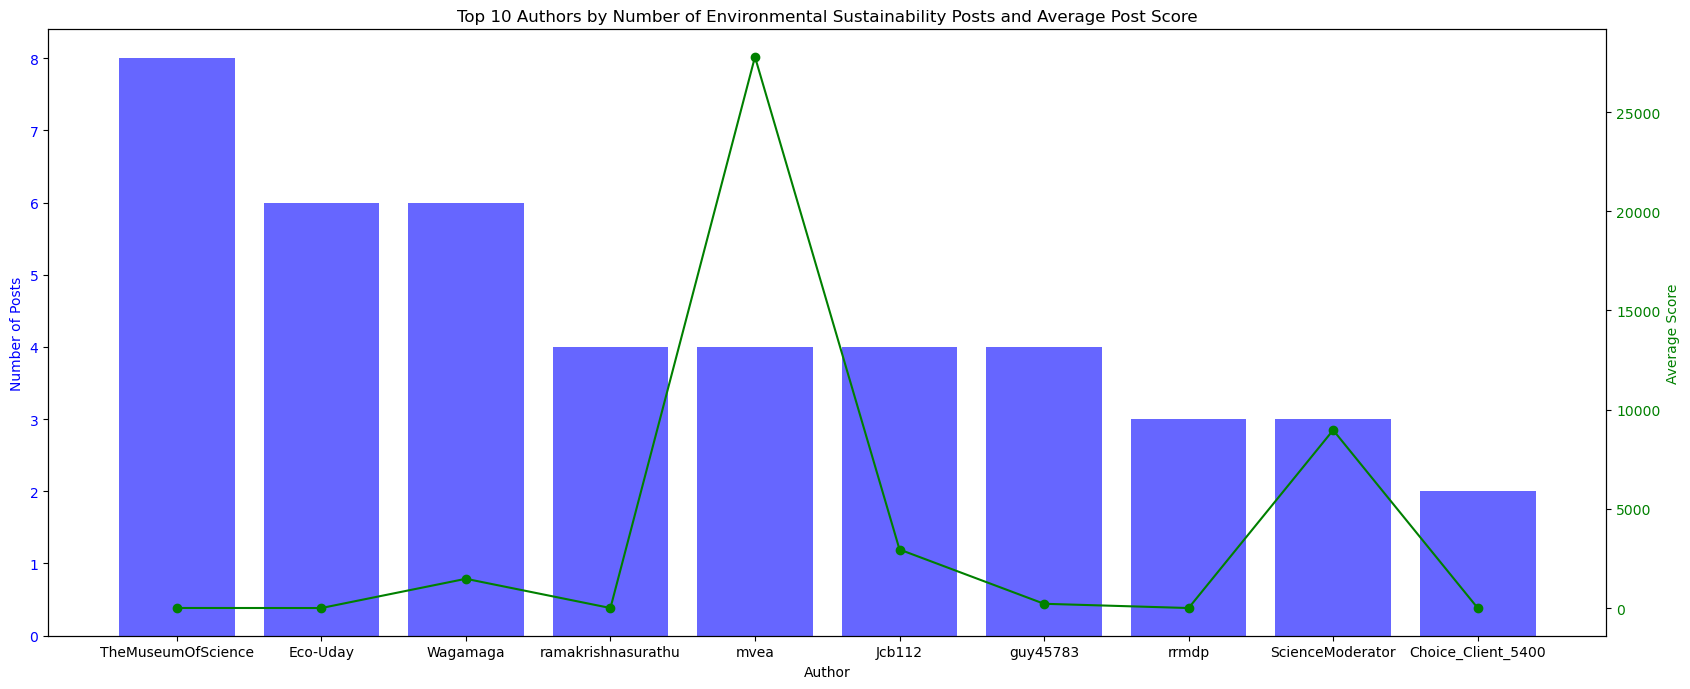

In [72]:
author_stats = df_posts.groupby('Author').agg(
    num_posts=('Post ID', 'count'),  # Number of posts by each author
    avg_score=('Score', 'mean')      # Average score of posts by the author
).reset_index()

# Sort the authors by the number of posts and take the top 10
top_10_authors = author_stats.sort_values(by='num_posts', ascending=False).head(10)

# Create a figure and axis for the dual-axis plot
fig, ax1 = plt.subplots(figsize=(17,7))

# Plot the number of posts as bars on the first y-axis
ax1.set_xlabel('Author')
ax1.set_ylabel('Number of Posts', color='blue')
ax1.bar(top_10_authors['Author'], top_10_authors['num_posts'], color='blue', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the average post score
ax2 = ax1.twinx()
ax2.set_ylabel('Average Score', color='green')
ax2.plot(top_10_authors['Author'], top_10_authors['avg_score'], color='green', marker='o')
ax2.tick_params(axis='y', labelcolor='green')

# Add a title and show the plot
plt.title('Top 10 Authors by Number of Environmental Sustainability Posts and Average Post Score')
plt.xticks(rotation=180)
plt.tight_layout()
plt.show()

In [73]:
mv_posts = df_posts[df_posts['Author'].str.lower() == 'mvea']

# Print all the posts from the 'science' subreddit
print(mv_posts)

                                           Post Title Author  Score  \
2   Chemists developed two sustainable plastic alt...   mvea  71981   
6   A model for ‘sustainable’ US beef production -...   mvea  32133   
16  Fracking is one of the least sustainable ways ...   mvea   5688   
30  Not having children a way to cut a person's ca...   mvea   1308   

    Comments Count Post ID                                           Post URL  \
2             1115  lo5vco  https://academictimes.com/new-plant-based-plas...   
6             3287  7mebyz  https://www.nature.com/articles/s41559-017-0390-5   
16             275  7qrvka  http://www.independent.co.uk/environment/frack...   
30             227  bbldzx  https://www.cbc.ca/news/canada/british-columbi...   

          Created Date          Subreddit Post Text  Subscribers  Link Karma  \
2  2021-02-20 13:09:12            science       N/A     33031202    30116251   
6  2017-12-27 11:40:58            science       N/A     33031204    30116251  

In [74]:
for index, title in enumerate(mv_posts['Post Title'], start=1):
    print(f"Post {index}:\n{title}")
    print("-" * 40)

Post 1:
Chemists developed two sustainable plastic alternatives to polyethylene, derived from plants, that can be recycled with a recovery rate of more than 96%, as low-waste, environmentally friendly replacements to conventional fossil fuel-based plastics. (Nature, 17 Feb)
----------------------------------------
Post 2:
A model for ‘sustainable’ US beef production - If Americans reduced their mean beef consumption from the current ≈460 g per person per week to ≈200 g per person per week (corresponding to f = 0.5), the US beef industry could become environmentally sustainable.
----------------------------------------
Post 3:
Fracking is one of the least sustainable ways to produce electricity, says new study. When comparing environmental, economic and social sustainability, scientists find shale gas extraction ranks 7th out of 9 different energy sources.
----------------------------------------
Post 4:
Not having children a way to cut a person's carbon footprint, some environmental gr

innovative solutions, straightforward and quantifiable solution, topic of significant public and scientific interest. Overall, the posts cover a wide range of sustainability topics, from innovative technologies to lifestyle changes, giving a good variety of solutions and challenges related to environmental sustainability

In [76]:
eco_posts = df_posts[df_posts['Author'].str.lower() == 'eco-uday']
for index, title in enumerate(eco_posts['Post Title'], start=1):
    print(f"Post {index}:\n{title}")
    print("-" * 40)

Post 1:
15 Environmentally Sustainable Activities
----------------------------------------
Post 2:
15 Environmentally Sustainable Activities
----------------------------------------
Post 3:
15 Environmentally Sustainable Activities
----------------------------------------
Post 4:
15 Environmentally Sustainable Activities
----------------------------------------
Post 5:
15 Environmentally Sustainable Activities
----------------------------------------
Post 6:
15 Environmentally Sustainable Activities
----------------------------------------


In [77]:
eco_posts

,Post Title,Author,Score,Comments Count,Post ID,Post URL,Created Date,Subreddit,Post Text,Subscribers,Link Karma,Comment Karma,Cleaned Post Text,Sentiment Scores,Compound,Sentiment,Log Score
167,15 Environmentally Sustainable Activities,Eco-Uday,1,0,1gfbudd,https://happyecofriendly.com/15-environmentall...,2024-10-30 03:00:33,HappyEcoFriendly,N/A,520,9,0,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0,neutral,0.693147
180,15 Environmentally Sustainable Activities,Eco-Uday,1,0,1g9zd7w,https://happyecofriendly.com/15-environmentall...,2024-10-23 04:00:19,HappyEcoFriendly,N/A,520,9,0,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0,neutral,0.693147
192,15 Environmentally Sustainable Activities,Eco-Uday,1,0,1g4ojru,https://happyecofriendly.com/15-environmentall...,2024-10-16 04:00:20,HappyEcoFriendly,N/A,520,9,0,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0,neutral,0.693147
203,15 Environmentally Sustainable Activities,Eco-Uday,1,0,1fzgrbd,https://happyecofriendly.com/15-environmentall...,2024-10-09 04:00:17,HappyEcoFriendly,N/A,520,9,0,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0,neutral,0.693147
219,15 Environmentally Sustainable Activities,Eco-Uday,1,0,1fu5brr,https://happyecofriendly.com/15-environmentall...,2024-10-02 04:00:21,HappyEcoFriendly,N/A,520,9,0,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0,neutral,0.693147
232,15 Environmentally Sustainable Activities,Eco-Uday,1,0,1fotj73,https://happyecofriendly.com/15-environmentall...,2024-09-25 04:00:19,HappyEcoFriendly,N/A,520,9,0,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0,neutral,0.693147


In [78]:
waga_posts = df_posts[df_posts['Author'].str.lower() == 'wagamaga']
for index, title in enumerate(waga_posts['Post Title'], start=1):
    print(f"Post {index}:\n{title}")
    print("-" * 40)

Post 1:
Chronic inflammation caused by stress is affecting our collective thinking and behavior, and it’s keeping society in a “self-sustaining cycle of societal dysfunction and environmental degradation” which is keeping us from taking action on issues like climate change and social unrest
----------------------------------------
Post 2:
Trump Policies Sent U.S. Tumbling in a Climate Ranking. The Environmental Performance Index, published every two years by researchers at Yale and Columbia, found only Denmark and Britain on sustainable paths to net-zero emissions by 2050.
----------------------------------------
Post 3:
Sustainable alternatives key to combating fast fashion's environmental toll. In 2018, over 11.3 million tons of clothing and textiles were discarded, creating serious environmental challenges.
----------------------------------------
Post 4:
Deutsche Bank: Crypto is not environmentally sustainable. Mining just one bitcoin consumes a larger carbon footprint than nearly 

In [79]:
df_posts.to_csv('EnSu.csv', index=False)